# Analysis of Uniform Noise in Trilocal Chain

This notebook considers uniform noise across all qubits in the trilocal chain network.

In [1]:
import pennylane as qml
from pennylane import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt

from context import QNetOptimizer as QNopt

In [2]:
def trace_distance(A, B):
    return np.sum([np.abs(eig_val) for eig_val in linalg.svd(A - B, hermitian=True)[1]])/2

In [3]:
def RY_CNOT(settings, wires):
    qml.RY(settings[0], wires=wires[0])
    qml.RY(settings[1], wires=wires[1])
    qml.CNOT(wires=wires[0:2])

bell_prep_nodes = [
    QNopt.PrepareNode(1, [0, 1], RY_CNOT, 2),
    QNopt.PrepareNode(1, [2, 3], RY_CNOT, 2),
    QNopt.PrepareNode(1, [4, 5], RY_CNOT, 2),
]
arb_prep_nodes = [
    QNopt.PrepareNode(1, [0, 1], qml.templates.subroutines.ArbitraryUnitary, 15),
    QNopt.PrepareNode(1, [2, 3], qml.templates.subroutines.ArbitraryUnitary, 15)
]

RY_meas_nodes = [
    QNopt.MeasureNode(2, 2, [0], QNopt.local_RY, 1),
    QNopt.MeasureNode(2, 2, [1,2], QNopt.local_RY, 2),
    QNopt.MeasureNode(2, 2, [3,4], QNopt.local_RY, 2),
    QNopt.MeasureNode(2, 2, [5], QNopt.local_RY, 1),
]

arb_meas_nodes = [
    QNopt.MeasureNode(2, 2, [0], qml.templates.subroutines.ArbitraryUnitary, 3),
    QNopt.MeasureNode(2, 2, [1,2], qml.templates.subroutines.ArbitraryUnitary, 15),
    QNopt.MeasureNode(2, 2, [3], qml.templates.subroutines.ArbitraryUnitary, 3)
]

## Main Function for scanning through noise parameters

In [6]:
def scan_channel_robustness(prep_nodes, meas_nodes, qubit_channel, scan_params):
    
    opt_violations = []
    noiseless_violations = []
    
    depolarized_distances = []
    noiseless_depolarized_distances = []
    
    classical_distances = []
    noiseless_classical_distances = []
    
    ideal_bilocal_ansatz = QNopt.NetworkAnsatz(prep_nodes, meas_nodes)
    noiseless_bilocal_cost = QNopt.nlocal_chain_cost_22(ideal_bilocal_ansatz)
    for chan_params in scan_params:
        
        print(chan_params)
        
        noise_nodes = [
            QNopt.NoiseNode([0], lambda settings, wires: qubit_channel(chan_params[0], wires=wires[0])),
            QNopt.NoiseNode([1], lambda settings, wires: qubit_channel(chan_params[1], wires=wires[0])),
            QNopt.NoiseNode([2], lambda settings, wires: qubit_channel(chan_params[2], wires=wires[0])),
            QNopt.NoiseNode([3], lambda settings, wires: qubit_channel(chan_params[3], wires=wires[0])),
            QNopt.NoiseNode([4], lambda settings, wires: qubit_channel(chan_params[4], wires=wires[0])),
            QNopt.NoiseNode([5], lambda settings, wires: qubit_channel(chan_params[5], wires=wires[0]))
        ]
        
        noisy_bilocal_ansatz = QNopt.NetworkAnsatz(prep_nodes, meas_nodes, noise_nodes)
        
        @qml.qnode(noisy_bilocal_ansatz.dev)
        def noisy_state(prep_settings):
            noisy_bilocal_ansatz.circuit_layer(noisy_bilocal_ansatz.prepare_nodes)(prep_settings)
            noisy_bilocal_ansatz.circuit_layer(noisy_bilocal_ansatz.noise_nodes)(chan_params)
            
            return qml.state()
        
        @qml.qnode(noisy_bilocal_ansatz.dev)
        def noiseless_state(prep_settings):
            ideal_bilocal_ansatz.circuit_layer(ideal_bilocal_ansatz.prepare_nodes)(prep_settings)
            
            return qml.state()

        noisy_bilocal_cost = QNopt.nlocal_chain_cost_22(noisy_bilocal_ansatz)
        init_settings = noisy_bilocal_ansatz.rand_scenario_settings()
    
        opt_dict = QNopt.gradient_descent(
            noisy_bilocal_cost,
            init_settings,
            num_steps = 40,
            step_size = 0.6,
            sample_width = 5,
            verbose=True
        )    
        
        opt_violations.append(opt_dict["opt_score"])
        noiseless_violations.append(-(noiseless_bilocal_cost(opt_dict["opt_settings"])))
                
        noisy_rho = noisy_state(noisy_bilocal_ansatz.layer_settings(opt_dict["opt_settings"][0], [0,0,0]))
        ideal_rho = noiseless_state(noisy_bilocal_ansatz.layer_settings(opt_dict["opt_settings"][0], [0,0,0]))
        
        depolarized_distances.append(trace_distance(noisy_rho, np.eye(64)/64))
        noiseless_depolarized_distances.append(trace_distance(ideal_rho, np.eye(64)/64))
        
        classical_distances.append(trace_distance(noisy_rho, np.diagflat(np.diag(noisy_rho))))
        noiseless_classical_distances.append(
            trace_distance(ideal_rho, np.diagflat(np.diag(ideal_rho)))
        )
    
    return (
        opt_violations,
        noiseless_violations,
        depolarized_distances,
        noiseless_depolarized_distances,
        classical_distances,
        noiseless_classical_distances,
    )

params_range = a = np.append(np.arange(0,1,0.1),[0.99999])
params_range.requires_grad=False

params = [[p,p,p,p,p,p] for p in params_range]

## Depolarizing Noise

In [7]:
%%time

(
    depo_violations,
    depo_noiseless_violations,
    depo_depolarized_distances,
    depo_noiseless_depolarized_distances,
    depo_classical_distances,
    depo_noiseless_classical_distances,
) = scan_channel_robustness(bell_prep_nodes, RY_meas_nodes, qml.DepolarizingChannel, params)

[tensor(0., requires_grad=False), tensor(0., requires_grad=False), tensor(0., requires_grad=False), tensor(0., requires_grad=False), tensor(0., requires_grad=False), tensor(0., requires_grad=False)]
iteration :  0 , score :  0.3785426376307565
elapsed time :  3.0954031944274902
iteration :  5 , score :  0.9658058501018756
elapsed time :  3.072620153427124
iteration :  10 , score :  1.0546526630904056
elapsed time :  3.0253748893737793
iteration :  15 , score :  1.1193872167099443
elapsed time :  3.0076560974121094
iteration :  20 , score :  1.2078532862825635
elapsed time :  3.0642261505126953
iteration :  25 , score :  1.3135372887740928
elapsed time :  3.1661298274993896
iteration :  30 , score :  1.3884139285347898
elapsed time :  3.0957961082458496
iteration :  35 , score :  1.4106397274936948
elapsed time :  3.161815881729126
[tensor(0.1, requires_grad=False), tensor(0.1, requires_grad=False), tensor(0.1, requires_grad=False), tensor(0.1, requires_grad=False), tensor(0.1, requires

elapsed time :  3.0840320587158203
iteration :  20 , score :  0.00251075757637667
elapsed time :  3.2076401710510254
iteration :  25 , score :  0.002612638831495384
elapsed time :  3.049527883529663
iteration :  30 , score :  0.002709866651971537
elapsed time :  3.1476821899414062
iteration :  35 , score :  0.0028032310761523793
elapsed time :  3.5973849296569824
[tensor(0.99999, requires_grad=False), tensor(0.99999, requires_grad=False), tensor(0.99999, requires_grad=False), tensor(0.99999, requires_grad=False), tensor(0.99999, requires_grad=False), tensor(0.99999, requires_grad=False)]
iteration :  0 , score :  0.019599329596920217
elapsed time :  3.1413700580596924
iteration :  5 , score :  0.021970236508984345
elapsed time :  3.323457956314087
iteration :  10 , score :  0.02400743006571093
elapsed time :  3.4554572105407715
iteration :  15 , score :  0.025776352130623167
elapsed time :  3.254497766494751
iteration :  20 , score :  0.02731580104131501
elapsed time :  3.2144298553466

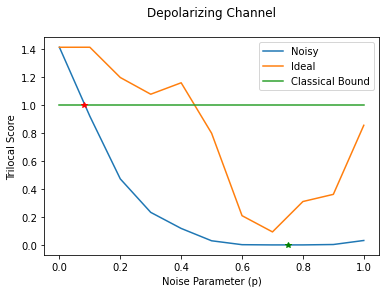

In [12]:
plt.plot(np.arange(0,1.1,0.1), depo_violations, label="Noisy")
plt.plot(np.arange(0,1.1,0.1), depo_noiseless_violations, label="Ideal")
plt.plot(np.arange(0,1.1,0.1), [1]*11, label="Classical Bound" )
plt.plot([(1-1/2**(1/6))*3/4], [1], "r*")
plt.plot([3/4],[0], "g*")
plt.legend()
plt.title("Depolarizing Channel\n")
plt.ylabel("Trilocal Score")
plt.xlabel("Noise Parameter (p)")
plt.show()

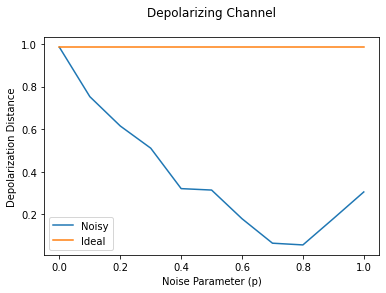

In [13]:
plt.plot(np.arange(0,1.1,0.1), depo_depolarized_distances, label="Noisy")
plt.plot(np.arange(0,1.1,0.1), depo_noiseless_depolarized_distances, label="Ideal")
plt.title("Depolarizing Channel\n")
plt.ylabel("Depolarization Distance")
plt.legend()
plt.xlabel("Noise Parameter (p)")
plt.show()

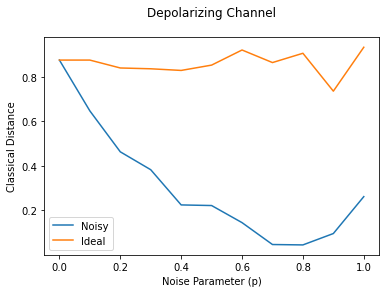

In [14]:
plt.plot(np.arange(0,1.1,0.1), depo_classical_distances, label="Noisy")
plt.plot(np.arange(0,1.1,0.1), depo_noiseless_classical_distances, label="Ideal")
plt.title("Depolarizing Channel\n")
plt.ylabel("Classical Distance")
plt.xlabel("Noise Parameter (p)")
plt.legend()
plt.show()

## Amplitude Damping

In [15]:
%%time

(
    ampdamp_violations,
    ampdamp_noiseless_violations,
    ampdamp_depolarized_distances,
    ampdamp_noiseless_depolarized_distances,
    ampdamp_classical_distances,
    ampdamp_noiseless_classical_distances,
) = scan_channel_robustness(bell_prep_nodes, RY_meas_nodes, qml.AmplitudeDamping, params)

[tensor(0., requires_grad=False), tensor(0., requires_grad=False), tensor(0., requires_grad=False), tensor(0., requires_grad=False), tensor(0., requires_grad=False), tensor(0., requires_grad=False)]
iteration :  0 , score :  0.07797684953986228
elapsed time :  2.3279788494110107
iteration :  5 , score :  0.869767633197906
elapsed time :  2.464959144592285
iteration :  10 , score :  1.1134366305203474
elapsed time :  2.3392720222473145
iteration :  15 , score :  1.2002968924197646
elapsed time :  2.503627061843872
iteration :  20 , score :  1.268524111894863
elapsed time :  2.3441760540008545
iteration :  25 , score :  1.347428870023419
elapsed time :  2.3293681144714355
iteration :  30 , score :  1.3994898449534632
elapsed time :  2.2923648357391357
iteration :  35 , score :  1.412343756962881
elapsed time :  2.3048839569091797
[tensor(0.1, requires_grad=False), tensor(0.1, requires_grad=False), tensor(0.1, requires_grad=False), tensor(0.1, requires_grad=False), tensor(0.1, requires_gr

elapsed time :  2.240173101425171
iteration :  25 , score :  0.8315941791345822
elapsed time :  2.2178897857666016
iteration :  30 , score :  0.8504256927501543
elapsed time :  2.1835620403289795
iteration :  35 , score :  0.8660533038490119
elapsed time :  2.175562858581543
[tensor(0.99999, requires_grad=False), tensor(0.99999, requires_grad=False), tensor(0.99999, requires_grad=False), tensor(0.99999, requires_grad=False), tensor(0.99999, requires_grad=False), tensor(0.99999, requires_grad=False)]
iteration :  0 , score :  0.11781153402411061
elapsed time :  2.2371160984039307
iteration :  5 , score :  0.6498963122373753
elapsed time :  2.278885841369629
iteration :  10 , score :  0.9161802935364375
elapsed time :  4.598031044006348
iteration :  15 , score :  0.9730575051463257
elapsed time :  2.194385051727295
iteration :  20 , score :  0.9871883817444589
elapsed time :  2.2237839698791504
iteration :  25 , score :  0.9929506196258896
elapsed time :  2.2359461784362793
iteration :  

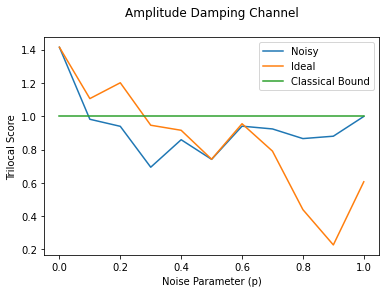

In [16]:
plt.plot(np.arange(0,1.1,0.1), ampdamp_violations, label="Noisy")
plt.plot(np.arange(0,1.1,0.1), ampdamp_noiseless_violations, label="Ideal")
plt.plot(np.arange(0,1.1,0.1), [1]*11, label="Classical Bound" )
plt.title("Amplitude Damping Channel\n")
plt.legend()
plt.ylabel("Trilocal Score")
plt.xlabel("Noise Parameter (p)")
plt.show()

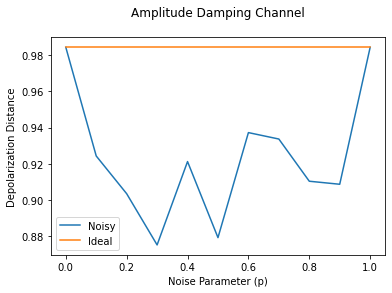

In [17]:
plt.plot(np.arange(0,1.1,0.1), ampdamp_depolarized_distances, label="Noisy")
plt.plot(np.arange(0,1.1,0.1), ampdamp_noiseless_depolarized_distances, label="Ideal")
plt.legend()
plt.title("Amplitude Damping Channel\n")
plt.ylabel("Depolarization Distance")
plt.xlabel("Noise Parameter (p)")
plt.show()

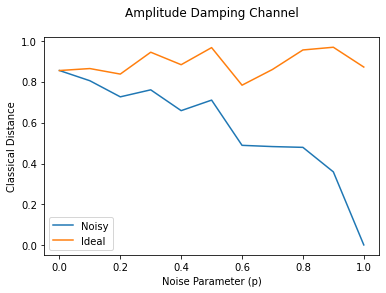

In [18]:
plt.plot(np.arange(0,1.1,0.1), ampdamp_classical_distances, label="Noisy")
plt.plot(np.arange(0,1.1,0.1), ampdamp_noiseless_classical_distances, label="Ideal")
plt.title("Amplitude Damping Channel\n")
plt.ylabel("Classical Distance")
plt.xlabel("Noise Parameter (p)")
plt.legend()
plt.show()

## Phase Damping

In [19]:
%%time

(
    phasedamp_violations,
    phasedamp_noiseless_violations,
    phasedamp_depolarized_distances,
    phasedamp_noiseless_depolarized_distances,
    phasedamp_classical_distances,
    phasedamp_noiseless_classical_distances,
) = scan_channel_robustness(bell_prep_nodes, RY_meas_nodes, qml.PhaseDamping, params)

[tensor(0., requires_grad=False), tensor(0., requires_grad=False), tensor(0., requires_grad=False), tensor(0., requires_grad=False), tensor(0., requires_grad=False), tensor(0., requires_grad=False)]
iteration :  0 , score :  0.3370452978889974
elapsed time :  2.1908669471740723
iteration :  5 , score :  1.1679156207597754
elapsed time :  2.232232093811035
iteration :  10 , score :  1.3411216519238836
elapsed time :  2.1805121898651123
iteration :  15 , score :  1.4003107386484088
elapsed time :  2.3135180473327637
iteration :  20 , score :  1.412520712475791
elapsed time :  2.248929977416992
iteration :  25 , score :  1.4140399747014718
elapsed time :  2.2315049171447754
iteration :  30 , score :  1.4141964287252409
elapsed time :  2.236117124557495
iteration :  35 , score :  1.4142118554955017
elapsed time :  2.217949867248535
[tensor(0.1, requires_grad=False), tensor(0.1, requires_grad=False), tensor(0.1, requires_grad=False), tensor(0.1, requires_grad=False), tensor(0.1, requires_gr

iteration :  25 , score :  0.9703101841826669
elapsed time :  2.2465758323669434
iteration :  30 , score :  0.99754378398608
elapsed time :  2.242047071456909
iteration :  35 , score :  1.0015377448427343
elapsed time :  2.2171671390533447
[tensor(0.99999, requires_grad=False), tensor(0.99999, requires_grad=False), tensor(0.99999, requires_grad=False), tensor(0.99999, requires_grad=False), tensor(0.99999, requires_grad=False), tensor(0.99999, requires_grad=False)]
iteration :  0 , score :  0.08297080674807629
elapsed time :  2.215710163116455
iteration :  5 , score :  0.6109458520069349
elapsed time :  2.2117228507995605
iteration :  10 , score :  0.9324481612999275
elapsed time :  2.2243947982788086
iteration :  15 , score :  0.987732542067294
elapsed time :  2.2003960609436035
iteration :  20 , score :  0.99732622781967
elapsed time :  2.1998250484466553
iteration :  25 , score :  0.9993734122734839
elapsed time :  2.183554172515869
iteration :  30 , score :  0.9998477840293349
elaps

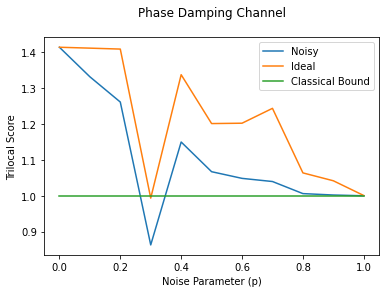

In [20]:
plt.plot(np.arange(0,1.1,0.1), phasedamp_violations, label="Noisy")
plt.plot(np.arange(0,1.1,0.1), phasedamp_noiseless_violations, label="Ideal")
plt.plot(np.arange(0,1.1,0.1), [1]*11, label="Classical Bound" )
plt.legend()
plt.title("Phase Damping Channel\n")
plt.ylabel("Trilocal Score")
plt.xlabel("Noise Parameter (p)")
plt.show()

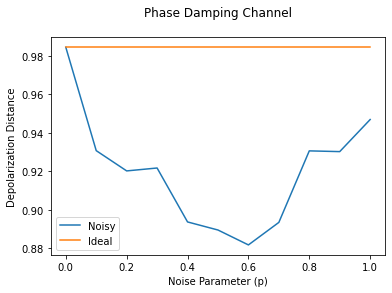

In [21]:
plt.plot(np.arange(0,1.1,0.1), phasedamp_depolarized_distances, label="Noisy")
plt.plot(np.arange(0,1.1,0.1), phasedamp_noiseless_depolarized_distances, label="Ideal")
plt.title("Phase Damping Channel\n")
plt.ylabel("Depolarization Distance")
plt.xlabel("Noise Parameter (p)")
plt.legend()
plt.show()

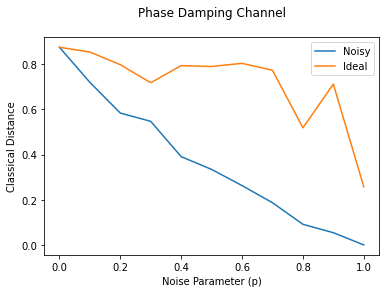

In [22]:
plt.plot(np.arange(0,1.1,0.1), phasedamp_classical_distances, label="Noisy")
plt.plot(np.arange(0,1.1,0.1), phasedamp_noiseless_classical_distances, label="Ideal")
plt.title("Phase Damping Channel\n")
plt.ylabel("Classical Distance")
plt.xlabel("Noise Parameter (p)")
plt.legend()
plt.show()

## Bit Flip Noise

In [23]:
%%time

(
    bitflip_violations,
    bitflip_noiseless_violations,
    bitflip_depolarized_distances,
    bitflip_noiseless_depolarized_distances,
    bitflip_classical_distances,
    bitflip_noiseless_classical_distances,
) = scan_channel_robustness(bell_prep_nodes, RY_meas_nodes, qml.BitFlip, params)

[tensor(0., requires_grad=False), tensor(0., requires_grad=False), tensor(0., requires_grad=False), tensor(0., requires_grad=False), tensor(0., requires_grad=False), tensor(0., requires_grad=False)]
iteration :  0 , score :  0.3190774899715414
elapsed time :  2.196315050125122
iteration :  5 , score :  1.0416429350406315
elapsed time :  2.223017930984497
iteration :  10 , score :  1.3226602917122492
elapsed time :  2.270937919616699
iteration :  15 , score :  1.3988541021240202
elapsed time :  2.261504888534546
iteration :  20 , score :  1.411936639180902
elapsed time :  2.213459014892578
iteration :  25 , score :  1.4137821867824283
elapsed time :  2.224153757095337
iteration :  30 , score :  1.4141008053616815
elapsed time :  2.2506749629974365
iteration :  35 , score :  1.41417835618347
elapsed time :  2.228355884552002
[tensor(0.1, requires_grad=False), tensor(0.1, requires_grad=False), tensor(0.1, requires_grad=False), tensor(0.1, requires_grad=False), tensor(0.1, requires_grad=Fa

iteration :  25 , score :  0.9761386580264992
elapsed time :  2.188850164413452
iteration :  30 , score :  0.9891550604333921
elapsed time :  2.212394952774048
iteration :  35 , score :  1.00044951580318
elapsed time :  2.224820137023926
[tensor(0.99999, requires_grad=False), tensor(0.99999, requires_grad=False), tensor(0.99999, requires_grad=False), tensor(0.99999, requires_grad=False), tensor(0.99999, requires_grad=False), tensor(0.99999, requires_grad=False)]
iteration :  0 , score :  0.44994566762100413
elapsed time :  2.2256429195404053
iteration :  5 , score :  1.0325174838651239
elapsed time :  2.1917221546173096
iteration :  10 , score :  1.1092635098057066
elapsed time :  2.2356348037719727
iteration :  15 , score :  1.2421753858583902
elapsed time :  2.2358312606811523
iteration :  20 , score :  1.3666293829902134
elapsed time :  2.232102155685425
iteration :  25 , score :  1.407371600430027
elapsed time :  2.2750048637390137
iteration :  30 , score :  1.4134497253957803
elap

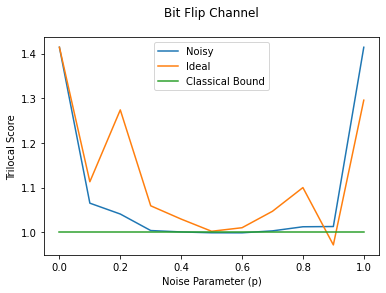

In [24]:
plt.plot(np.arange(0,1.1,0.1), bitflip_violations, label="Noisy")
plt.plot(np.arange(0,1.1,0.1), bitflip_noiseless_violations, label="Ideal")
plt.plot(np.arange(0,1.1,0.1), [1]*11, label="Classical Bound" )
plt.title("Bit Flip Channel\n")
plt.ylabel("Trilocal Score")
plt.xlabel("Noise Parameter (p)")
plt.legend()
plt.show()

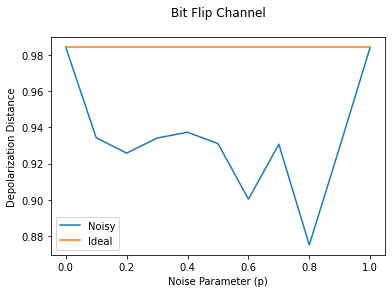

In [25]:
plt.plot(np.arange(0,1.1,0.1), bitflip_depolarized_distances, label="Noisy")
plt.plot(np.arange(0,1.1,0.1), bitflip_noiseless_depolarized_distances, label="Ideal")

plt.title("Bit Flip Channel\n")
plt.ylabel("Depolarization Distance")
plt.xlabel("Noise Parameter (p)")
plt.legend()
plt.show()

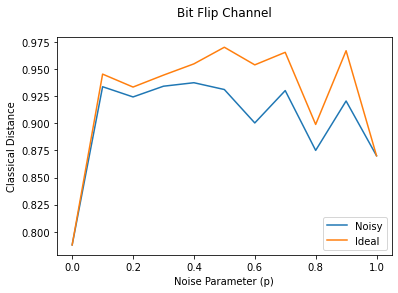

In [26]:
plt.plot(np.arange(0,1.1,0.1), bitflip_classical_distances, label="Noisy")
plt.plot(np.arange(0,1.1,0.1), bitflip_noiseless_classical_distances, label="Ideal")
plt.title("Bit Flip Channel\n")
plt.ylabel("Classical Distance")
plt.xlabel("Noise Parameter (p)")
plt.legend()
plt.show()

## Phase Flip

In [27]:
%%time

(
    phaseflip_violations,
    phaseflip_noiseless_violations,
    phaseflip_depolarized_distances,
    phaseflip_noiseless_depolarized_distances,
    phaseflip_classical_distances,
    phaseflip_noiseless_classical_distances
) = scan_channel_robustness(bell_prep_nodes, RY_meas_nodes, qml.PhaseFlip, params)

[tensor(0., requires_grad=False), tensor(0., requires_grad=False), tensor(0., requires_grad=False), tensor(0., requires_grad=False), tensor(0., requires_grad=False), tensor(0., requires_grad=False)]
iteration :  0 , score :  0.4501527841489935
elapsed time :  2.22800612449646
iteration :  5 , score :  0.962457217329087
elapsed time :  2.192934036254883
iteration :  10 , score :  1.012007131573883
elapsed time :  2.138463020324707
iteration :  15 , score :  1.0434780828796628
elapsed time :  2.2281408309936523
iteration :  20 , score :  1.086751347601906
elapsed time :  2.244590997695923
iteration :  25 , score :  1.1388026911252342
elapsed time :  2.255239963531494
iteration :  30 , score :  1.1909717577188679
elapsed time :  2.218129873275757
iteration :  35 , score :  1.2627930635745837
elapsed time :  2.253788709640503
[tensor(0.1, requires_grad=False), tensor(0.1, requires_grad=False), tensor(0.1, requires_grad=False), tensor(0.1, requires_grad=False), tensor(0.1, requires_grad=Fal

iteration :  25 , score :  1.0028629465223635
elapsed time :  2.225229024887085
iteration :  30 , score :  1.025480726970222
elapsed time :  2.2656688690185547
iteration :  35 , score :  1.04418133127037
elapsed time :  2.1829042434692383
[tensor(0.99999, requires_grad=False), tensor(0.99999, requires_grad=False), tensor(0.99999, requires_grad=False), tensor(0.99999, requires_grad=False), tensor(0.99999, requires_grad=False), tensor(0.99999, requires_grad=False)]
iteration :  0 , score :  0.4724393897155961
elapsed time :  2.218071937561035
iteration :  5 , score :  1.0517369070647824
elapsed time :  2.174376964569092
iteration :  10 , score :  1.1286403663317022
elapsed time :  2.2356488704681396
iteration :  15 , score :  1.173406154062381
elapsed time :  2.2466087341308594
iteration :  20 , score :  1.204742389123016
elapsed time :  2.2274868488311768
iteration :  25 , score :  1.2427836314436185
elapsed time :  2.2709500789642334
iteration :  30 , score :  1.3092903881826081
elapse

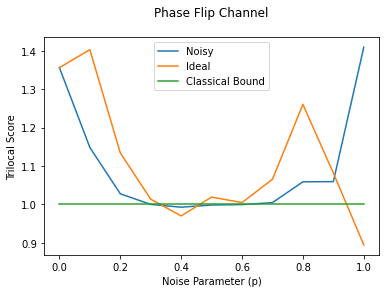

In [28]:
plt.plot(np.arange(0,1.1,0.1), phaseflip_violations, label="Noisy")
plt.plot(np.arange(0,1.1,0.1), phaseflip_noiseless_violations, label="Ideal")
plt.plot(np.arange(0,1.1,0.1), [1]*11, label="Classical Bound" )
plt.title("Phase Flip Channel\n")
plt.ylabel("Trilocal Score")
plt.xlabel("Noise Parameter (p)")
plt.legend()
plt.show()

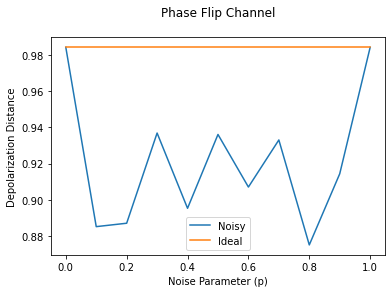

In [29]:
plt.plot(np.arange(0,1.1,0.1), phaseflip_depolarized_distances, label="Noisy")
plt.plot(np.arange(0,1.1,0.1), phaseflip_noiseless_depolarized_distances, label="Ideal")

plt.title("Phase Flip Channel\n")
plt.ylabel("Depolarization Distance")
plt.xlabel("Noise Parameter (p)")
plt.legend()
plt.show()

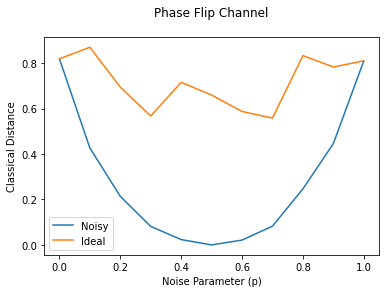

In [30]:
plt.plot(np.arange(0,1.1,0.1), phaseflip_classical_distances, label="Noisy")
plt.plot(np.arange(0,1.1,0.1), phaseflip_noiseless_classical_distances, label="Ideal")
plt.title("Phase Flip Channel\n")
plt.ylabel("Classical Distance")
plt.xlabel("Noise Parameter (p)")
plt.legend()
plt.show()